In [1]:
import os
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn
import pickle
from time import perf_counter
from sklearn.random_projection import GaussianRandomProjection

import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

class NetVLAD(nn.Module):
    def __init__(self, num_clusters=64, dim=512):
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
    
    def forward(self, x):
        N, C, H, W = x.shape  # N is batch size, C is the number of channels, H and W are height and width
        soft_assign = self.conv(x)  # [N, num_clusters, H, W]
        soft_assign = soft_assign.view(N, self.num_clusters, -1)  # [N, num_clusters, H*W]
        soft_assign = F.softmax(soft_assign, dim=1)  # Apply softmax along the clusters
        
        x_flatten = x.view(N, C, -1)  # Flatten the feature maps to [N, C, H*W]
        x_flatten = x_flatten.permute(0, 2, 1)  # Change to [N, H*W, C] for easier broadcasting
        
        vlad = torch.zeros([N, self.num_clusters, C], dtype=x.dtype, layout=x.layout, device=x.device)
        for Ck in range(self.num_clusters):
            residual = x_flatten - self.centroids[Ck:Ck + 1, :].expand(x_flatten.size(0), -1, -1)  # [N, H*W, C]
            residual *= soft_assign[:, Ck:Ck + 1, :].permute(0, 2, 1)  # [N, H*W, 1]
            vlad[:, Ck:Ck + 1, :] = residual.sum(dim=1)  # Sum over H*W dimension
            
        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(N, -1)  # Flatten to [N, num_clusters*C]
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize
        
        return vlad

def load_netvlad_model():
    backbone = models.vgg16(pretrained=True)
    netvlad_layer = nn.Sequential(
        *list(backbone.features.children())[:-2],
        NetVLAD(num_clusters=64)
    )
    return netvlad_layer

def compute_netvlad_descriptor(image_path, model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img_tensor = transform(img_rgb).unsqueeze(0)
    
    with torch.no_grad():
        descriptor = model(img_tensor)
    
    return descriptor.cpu().numpy()


def process_images_in_folder(folder_path, model):
    descriptors_list = []
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            descriptor = compute_netvlad_descriptor(image_path, model)
            descriptors_list.append(descriptor[0])
    
    return np.array(descriptors_list)


def preprocess_descriptors(desc_matr):
    #gaussian random projection
    transformer = GaussianRandomProjection(n_components=4096)
    desc_matr_new = transformer.fit_transform(desc_matr)
    #l2 normalization
    #desc_matr_new = normalize(desc_matr_new, axis=1, norm='l2')
    #dimensionwise standardization to standard normal distributions
        # Step 1: Compute the mean and standard deviation for each column
    mean = np.mean(desc_matr_new, axis=0)  # Mean along columns
    std_dev = np.std(desc_matr_new, axis=0)  # Standard deviation along columns

        # Step 2: Standardize the columns
    desc_matr_standardized = (desc_matr_new - mean) / std_dev
    
    return desc_matr_standardized

In [2]:
def sequential_cos_sim(db, q):
    #for x in range(db.shape[0]):
        #for y in range(q.shape[0]):
            #sim = skmet.pairwise.cosine_similarity(x,y)
    return skmet.pairwise.cosine_similarity(db,q)

In [3]:
folder_path = '../images/nordland/summer'
model = load_netvlad_model()
start = perf_counter()
summer_descriptors_list = process_images_in_folder(folder_path, model)
summer_descriptors_list_pp = preprocess_descriptors(summer_descriptors_list)
end = perf_counter()
duration = end - start
print(f"Duration creation descriptors: {duration} seconds")

/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Duration creation descriptors: 42.5369572500058 seconds


In [4]:
summer_descriptors_list_pp.shape

(600, 4096)

In [5]:
folder_path = '../images/nordland/winter'
model = load_netvlad_model()
start = perf_counter()
winter_descriptors_list = process_images_in_folder(folder_path, model)
winter_descriptors_list_pp = preprocess_descriptors(winter_descriptors_list)
end = perf_counter()
duration = end - start
print(f"Duration creation descriptors: {duration} seconds")

/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Duration creation descriptors: 42.36948266701074 seconds


In [6]:
folder_path = '../images/nordland/spring'
model = load_netvlad_model()
start = perf_counter()
spring_descriptors_list = process_images_in_folder(folder_path, model)
spring_descriptors_list_pp = preprocess_descriptors(spring_descriptors_list)
end = perf_counter()
duration = end - start
print(f"Duration creation descriptors: {duration} seconds")

/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Duration creation descriptors: 45.30412187500042 seconds


In [7]:
folder_path = '../images/nordland/fall'
model = load_netvlad_model()
start = perf_counter()
fall_descriptors_list = process_images_in_folder(folder_path, model)
fall_descriptors_list_pp = preprocess_descriptors(fall_descriptors_list)
end = perf_counter()
duration = end - start
print(f"Duration creation descriptors: {duration} seconds")

/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Duration creation descriptors: 42.57648774998961 seconds


In [8]:
np.save('./data/nordland/raw/summer', summer_descriptors_list_pp)
np.save('./data/nordland/raw/winter', winter_descriptors_list_pp)
np.save('./data/nordland/raw/spring', spring_descriptors_list_pp)
np.save('./data/nordland/raw/fall', fall_descriptors_list_pp)

In [9]:
import numpy as np
import scipy.io as sio
from scipy.sparse import lil_matrix
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json

import time
from time import perf_counter
import sklearn.metrics as skmet
from SEER.seer import seer

with open("./config.json") as c:
            config = json.load(c)
            nl_summer_raw_path = config["nl_summer_raw"]
            nl_spring_raw_path = config["nl_spring_raw"]
            nl_winter_raw_path = config["nl_winter_raw"]
            nl_fall_raw_path = config["nl_fall_raw"]
            
            nl_summer_mat_path = config["nl_summer_matrix"]
            nl_spring_mat_path = config["nl_spring_matrix"]
            nl_winter_mat_path = config["nl_winter_matrix"]
            nl_fall_mat_path = config["nl_fall_matrix"]
            
            nl_summer_seer_path = config["nl_summer_seer"]
            nl_spring_seer_path = config["nl_spring_seer"]
            nl_winter_seer_path = config["nl_winter_seer"]
            nl_fall_seer_path = config["nl_fall_seer"]
            
def print_gs_matrix(matrix):
    plt.imshow(matrix, cmap='gray')
    plt.colorbar()
    plt.show()
    
M_summer = None
k = 50 #number of needed exemplars, default 50
lambda_val = 2 #default is 2

nl_summer_seer = seer()
start = perf_counter()
M_summer, DS_summer = nl_summer_seer.compute_M_and_Y(M_summer, summer_descriptors_list_pp , 100, k, lambda_val)
end = perf_counter()
duration = end - start
print(f"Duration creation M: {duration} seconds")

expectedSim:  0.0244140625
  running image 1 of 600 (0 exemplars) 
  running image 11 of 600 (416 exemplars) 
  running image 21 of 600 (849 exemplars) 
  running image 31 of 600 (1147 exemplars) 
  running image 41 of 600 (1547 exemplars) 
  running image 51 of 600 (1971 exemplars) 
  running image 61 of 600 (2390 exemplars) 
  running image 71 of 600 (2737 exemplars) 
  running image 81 of 600 (3059 exemplars) 
  running image 91 of 600 (3304 exemplars) 
  running image 101 of 600 (3553 exemplars) 
  running image 111 of 600 (3989 exemplars) 
  running image 121 of 600 (4383 exemplars) 
  running image 131 of 600 (4816 exemplars) 
  running image 141 of 600 (5167 exemplars) 
  running image 151 of 600 (5522 exemplars) 
  running image 161 of 600 (5930 exemplars) 
  running image 171 of 600 (6258 exemplars) 
  running image 181 of 600 (6621 exemplars) 
  running image 191 of 600 (6869 exemplars) 
  running image 201 of 600 (7089 exemplars) 
  running image 211 of 600 (7285 exemplars) 

In [10]:
Q_winter_summer = nl_summer_seer.compute_seer_descriptors(winter_descriptors_list_pp, M_summer, lambda_val, k)
Q_spring_summer = nl_summer_seer.compute_seer_descriptors(spring_descriptors_list_pp, M_summer, lambda_val, k)
Q_fall_summer = nl_summer_seer.compute_seer_descriptors(fall_descriptors_list_pp, M_summer, lambda_val, k)

In [11]:
cos_sim_winter = sequential_cos_sim(DS_summer, Q_winter_summer)
cos_sim_fall = sequential_cos_sim(DS_summer, Q_fall_summer)
cos_sim_spring = sequential_cos_sim(DS_summer, Q_spring_summer)

Text(0.5, 1.0, 'Summer Spring')

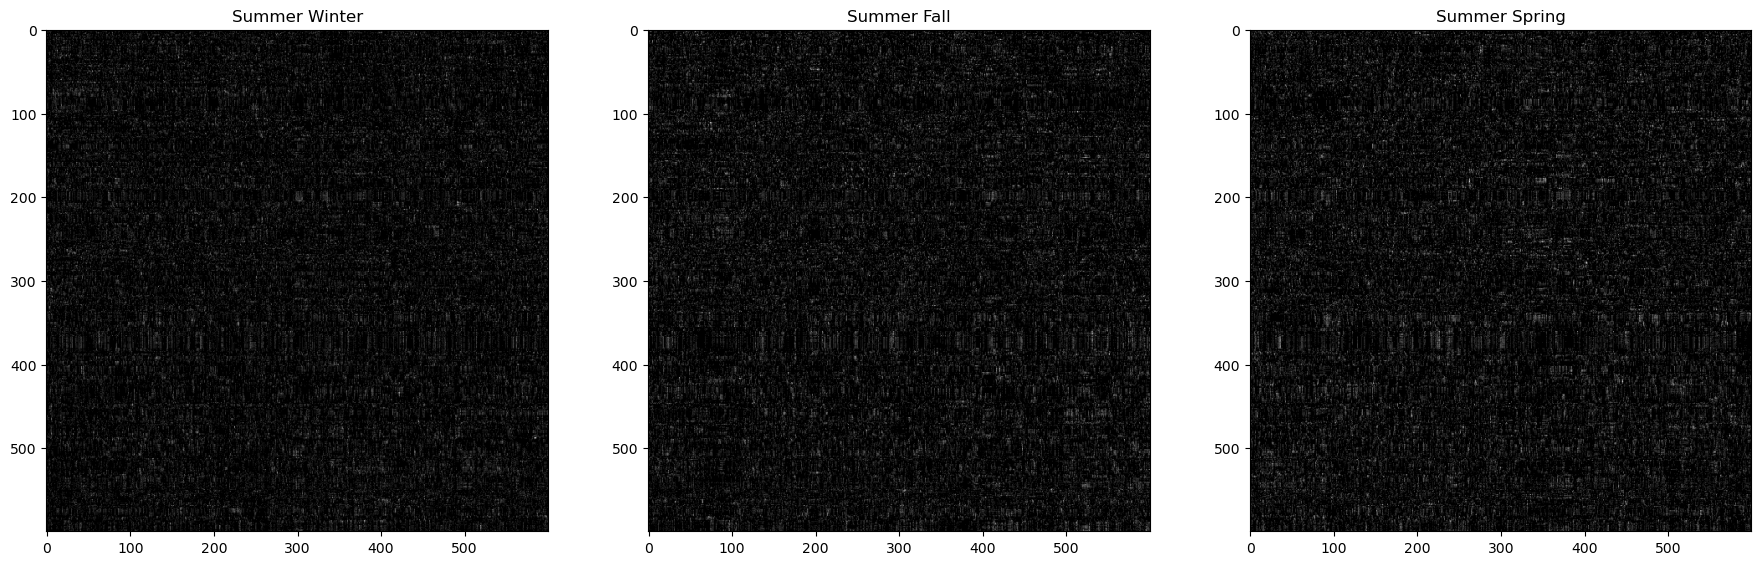

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22, 22))

ax1.imshow(cos_sim_winter, cmap='gray')
ax1.set_title("Summer Winter")

ax2.imshow(cos_sim_fall, cmap='gray')
ax2.set_title("Summer Fall")

ax3.imshow(cos_sim_spring, cmap='gray')
ax3.set_title("Summer Spring")